<h1><center><font size="6">Cursive Hiragana Images Classification</font></center></h1>


<img src="http://su-cultural-history.up.n.seesaa.net/su-cultural-history/image/P1030717.JPG?d=a48" width="200"></img>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Test prediction</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>

# <a id="1">Introduction</a>  


## Dataset

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.   

KMNIST (Kuzushiji-MNIST or Cursive hiragana-MNIST)  was introduced as an alternative to MNIST. It contains images with the first entries from the 10 main Japanese hiragana character groups.


## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.   

The images are storred in numpy arrays of 50,000 x 28 x 28 and 20,000 x 28 x 28, respectively. The labels for training set are also stored in a numpy array.


# <a id="2">Load packages</a>

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 

Using TensorFlow backend.


## Parameters

In [2]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
PATH="../input/"
print(os.listdir(PATH))

['train-labels.npz', 'test-imgs.npz', 'classmap.csv', 'train-imgs.npz', 'sample_submission.csv']


# <a id="3">Read the data</a>

We will read the two data files containing the 10-class data, KMNIST, similar to MNIST.

There are 10 different classes of images, one class for each number between 0 and 9. 

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate numpy arrays.   

We are also reading the labels for train set.

Aditionally, we will read the character class map for KMNIST, so that we can display the actual characters corresponding to the labels.


In [3]:
train_images = np.load(os.path.join(PATH,'train-imgs.npz'))['arr_0']
test_images = np.load(os.path.join(PATH,'test-imgs.npz'))['arr_0']
train_labels = np.load(os.path.join(PATH,'train-labels.npz'))['arr_0']

In [4]:
char_df = pd.read_csv(os.path.join(PATH,'classmap.csv'), encoding = 'utf-8')

# <a id="4">Data exploration</a>

![](http://)The dimmension of the original  train,  test set are as following:

In [5]:
print("KMNIST train shape:", train_images.shape)
print("KMNIST test shape:", test_images.shape)
print("KMNIST train shape:", train_labels.shape)

KMNIST train shape: (50000, 28, 28)
KMNIST test shape: (20000, 28, 28)
KMNIST train shape: (50000,)


The dimmension of the character set data file for KMNIST are:

In [6]:
print("KMNIST character map shape:", char_df.shape)

KMNIST character map shape: (10, 3)


Let's show the character map:

In [7]:
char_df

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


## <a id="41">Class distribution</a>

Let's see how many number of images are in each class. 

### Train set images class distribution

In [8]:
print('Percent for each category:',np.bincount(train_labels)/len(train_labels)*100)

Percent for each category: [10.056  9.996  9.94   9.998  9.966 10.026  9.922 10.064  9.954 10.078]


The classes are allmost equaly distributed in the train set (being ~10% each, or ~5000 items).  Let's also plot a graph for these.

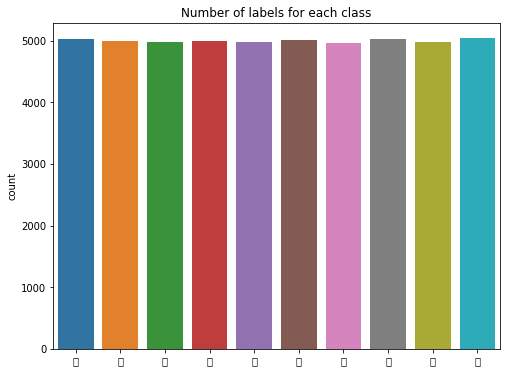

In [9]:
labels = char_df['char']
f, ax = plt.subplots(1,1, figsize=(8,6))
g = sns.countplot(train_labels)
g.set_title("Number of labels for each class")
g.set_xticklabels(labels)
plt.show()    

## <a id="42">Sample images</a>

### Train dataset images

Let's plot some samples for the images.

In [10]:
def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

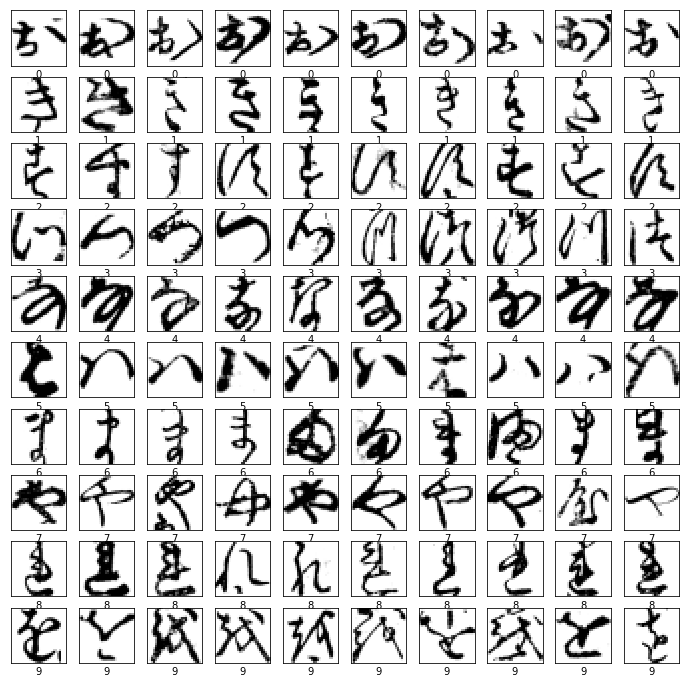

In [11]:
plot_sample_images_data(train_images, train_labels)

# <a id="5">Model</a>

We start with preparing the model.

## <a id="51">Prepare the model</a>

## Data preprocessing

First we will do a data preprocessing to prepare for the model.

We reshape the numpy arrays for images to associate to each image a (28 x 28 x 1) array, with values normalized.

In [12]:
# data preprocessing
def data_preprocessing(images):
    num_images = images.shape[0]
    x_shaped_array = images.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x

We process both the train_data and the test_data.

In [13]:
X = data_preprocessing(train_images)
y = keras.utils.to_categorical(train_labels, NUM_CLASSES)
X_test = data_preprocessing(test_images)

## Split train in train and validation set

We further split the train set in train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The dimmension of the processed train, validation and test set are as following:

In [15]:
print("KMNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("KMNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("KMNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

KMNIST train -  rows: 40000  columns: (28, 28, 1)
KMNIST valid -  rows: 10000  columns: (28, 28, 1)
KMNIST test -  rows: 20000  columns: (28, 28, 1)


Let's check the class imbalance for the resulted training set.

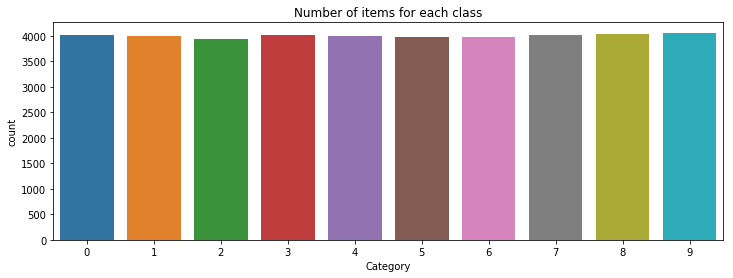

9(を):   4059 or 10.147499999999999%
8(れ):   4031 or 10.0775%
0(お):   4017 or 10.0425%
7(や):   4013 or 10.032499999999999%
3(つ):   4012 or 10.03%
4(な):   3995 or 9.9875%
1(き):   3995 or 9.9875%
6(ま):   3970 or 9.925%
5(は):   3969 or 9.9225%
2(す):   3939 or 9.8475%


In [16]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
            
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        label_char = char_df[char_df['index']==label]['char'].item()
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{}({}):   {} or {}%".format(label, label_char, count, percent))
    
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

Let's see also the class distribution of validation set.

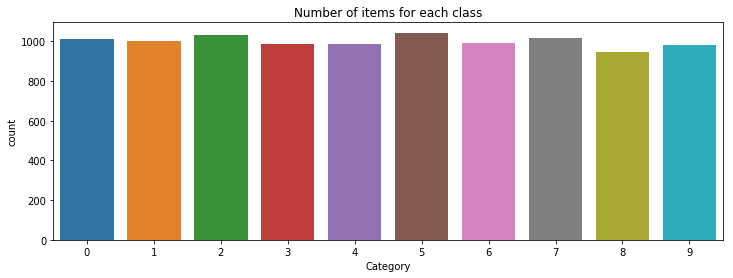

5(は):   1044 or 10.440000000000001%
2(す):   1031 or 10.31%
7(や):   1019 or 10.190000000000001%
0(お):   1011 or 10.11%
1(き):   1003 or 10.03%
6(ま):   991 or 9.91%
4(な):   988 or 9.879999999999999%
3(つ):   987 or 9.87%
9(を):   980 or 9.8%
8(れ):   946 or 9.46%


In [17]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

## <a id="52">Train the model</a>

### Build the model   





In [18]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', padding="same",
        kernel_initializer='he_normal',input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16,kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

### Compile the model
We then compile the model, with the layers and optimized defined.

In [19]:
# Compile the model
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Inspect the model

Let's check the model we initialized.

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                108170    
Total params: 110,778
Trainable params: 110,714
Non-trainable params: 64
_________________________________________________________________


### Run the model

We run the model with the training set. We are also using the validation set (a subset from the orginal training set) for validation.

In [21]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 116us/step - loss: 0.3914 - acc: 0.8907 - val_loss: 0.4721 - val_acc: 0.8485
Epoch 2/10
40000/40000 [==============================] - 2s 45us/step - loss: 0.1309 - acc: 0.9614 - val_loss: 0.2487 - val_acc: 0.9300
Epoch 3/10
40000/40000 [==============================] - 2s 45us/step - loss: 0.0637 - acc: 0.9816 - val_loss: 0.2333 - val_acc: 0.9410
Epoch 4/10
40000/40000 [==============================] - 2s 45us/step - loss: 0.0323 - acc: 0.9912 - val_loss: 0.2458 - val_acc: 0.9426
Epoch 5/10
40000/40000 [==============================] - 2s 44us/step - loss: 0.0190 - acc: 0.9963 - val_loss: 0.2525 - val_acc: 0.9440
Epoch 6/10
40000/40000 [==============================] - 2s 46us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.2781 - val_acc: 0.9412
Epoch 7/10
40000/40000 [==============================] - 2s 45us/step - loss: 0.0113 - acc: 0.9980 - val_loss: 0.2708 - val_ac


## <a id="53">Validation accuracy and  loss </a>


We plot accuracy for validation set compared with the accuracy of training set, for each epoch, on the same graph. Then, we plot loss for validation set compared with the loss for training set. 


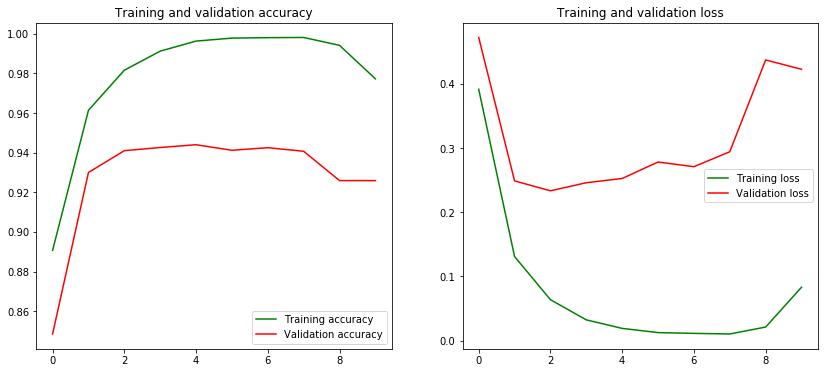

In [22]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)

The model used here is simplified, with the purpose to serve as a  baseline. For more complex models, please consult the references.

## <a id="54">Validation accuracy / class</a>

Let's see in detail how well are the validation set classes predicted.

In [23]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [24]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [25]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9259
Incorrect predicted classes: 741


In [26]:
target_names = ["Class {} ({}):".format(i, char_df[char_df['index']==i]['char'].item()) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

Class 0 (お):       0.94      0.95      0.95      1011
Class 1 (き):       0.93      0.94      0.94      1003
Class 2 (す):       0.87      0.91      0.89      1031
Class 3 (つ):       0.95      0.93      0.94       987
Class 4 (な):       0.93      0.88      0.90       988
Class 5 (は):       0.92      0.93      0.93      1044
Class 6 (ま):       0.94      0.88      0.91       991
Class 7 (や):       0.94      0.95      0.94      1019
Class 8 (れ):       0.95      0.91      0.93       946
Class 9 (を):       0.90      0.98      0.94       980

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




Let's visualize few images from the validation set that were correctly classified (25 images).

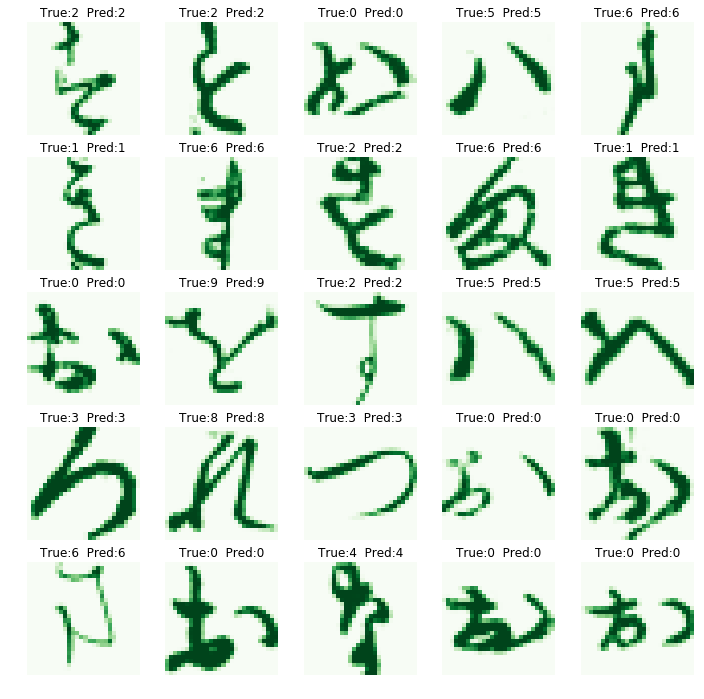

In [27]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,5, figsize=(12,12))

    for i, indx in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(X_val[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(y_true[indx],predicted_classes[indx]))
    plt.show()    

plot_images(correct, "Greens")

Let's visualize the images from the validation set that were incorrecly classified (25 images).

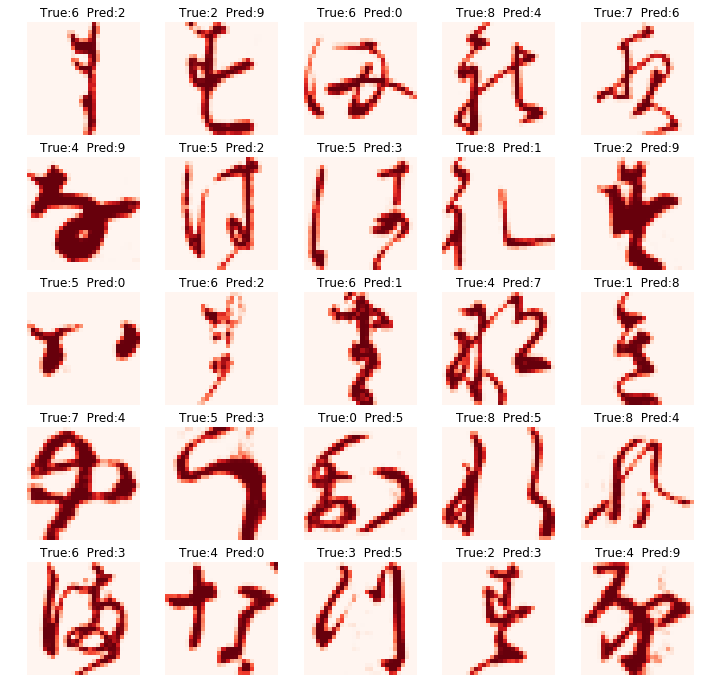

In [28]:
plot_images(incorrect, "Reds")

We identify the predicted class for each image by selecting the column with the highest predicted value.

# <a id="6">Test prediction</a>

Let's use the trained model to predict the labels for the test images.

In [29]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

# <a id="7">Submission</a>

Let's prepare the submission.


In [30]:
submission = pd.read_csv(os.path.join(PATH,"sample_submission.csv"))
submission['Class'] = predicted_classes
submission.to_csv(os.path.join(".","submission.csv"), index=False)

 <a id="8">References</a>

[1] Yan LeCun, MNIST Database, http://yann.lecun.com/exdb/mnist/  
[2] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[3] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[4] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras    
[5] Gabriel Preda, Simple introduction to CNN for MNIST (99.37%), https://www.kaggle.com/gpreda/simple-introduction-to-cnn-for-mnist-99-37  
[6] Anokas, KMNIST-MNIST replacement, https://www.kaggle.com/aakashnain/kmnist-mnist-replacement    
[7] Megan Risdal, Starter: Kuzushiji-MNIST, https://www.kaggle.com/mrisdal/starter-kuzushiji-mnist-ed86cfac-1   
[8] Kuzushiji-MNIST, project Github repo, https://github.com/rois-codh/kmnist   
[9] Tarin Clanuwat, Mikel Bober-Irizar, Asanobu Kitamoto, Alex Lamb, Kazuaki Yamamoto, David Ha, Deep Learning for Classical Japanese Literature, https://arxiv.org/abs/1812.01718  

